<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>

# 10 KNN distance distribution and Overall ellipsoid shape

Once that we have ellipsoid parameters for individual oil glands, and for the whole fruit, it is time to get everything together.

- We look at how spherical are the individual oil glands.
- We compute average distances between neighboring oil glands.
- We compute how different individual oil gland traits distribute across the fruit's latitudes.

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SW01_CRC3030_12B-8-5_L02_frontal_ell_projection.jpg" style="width:500px">
        <p style="text-align:center;font-size:20px">The whole fruit shape is approximated as the best-fit algebraic ellipsoid</p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/ell_glands_01000.jpg" alt = "barley" style="width:500px;"/>
        <p style="text-align:center;font-size:20px">Individual oil glands are approximated with MVEEs, minimum volume enclosing ellipsoids</p>
    </td>
  </tr>
</tbody>
</table>


In [1]:
import numpy as np
import tifffile as tf
import pandas as pd
import glob
import os

from scipy import special

from sklearn import neighbors as nn

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload

import citrus_utils as vitaminC
from mvee import EllipsoidTool as ET

### Load data

- All the diagnostic plots will be stored in `../data/glands/` following the usual naming conventions.

In [2]:
tissue_src = '../data/tissue/'
oil_dst = '../data/glands/'
oil_src = '../data/oil/'
bnames = [os.path.split(x)[-1] for x in sorted(glob.glob(oil_src + 'WR*'))]
et = ET()
for i in range(len(bnames)):
    print(i, '\t', bnames[i])

0 	 WR05_CRC3605_18B-19-5


In [3]:
bname = bnames[0]
L = 3

lname = 'L{:02d}'.format(L)

src = oil_src + bname + '/' + lname + '/' 
dst = oil_dst + bname + '/' + lname + '/'

if os.path.isdir(dst):
    pass
else:
    os.makedirs(dst)
print('save figures in directory', dst)

save figures in directory ../data/glands/WR05_CRC3605_18B-19-5/L03/


### Load voxel-size data

- The micron size of each voxel depends on the scanning parameters

In [4]:
voxel_filename = '../data/citrus_voxel_size.csv'
voxel_size = pd.read_csv(voxel_filename)
voxsize = (voxel_size.loc[voxel_size.ID == bname, 'voxel_size_microns'].values)[0]
print('Each voxel is of side', voxsize, 'microns')

Each voxel is of side 57.5 microns


### Load individual MVEE parameters for the individual oil glands

- Minimum volume enclosing ellipsoids

In [5]:
filename = src + bname + '_' + lname + '_cmvee.csv'
cmvee = np.loadtxt(filename, delimiter=',')
    
filename = src + bname + '_' + lname + '_amvee.csv'
amvee = np.loadtxt(filename, delimiter=',')

filename = src + bname + '_' + lname + '_dmvee.csv'
dmvee = np.loadtxt(filename, delimiter=',')

filename = src + bname + '_' + lname + '_rmvee.csv'
rmvee = np.loadtxt(filename, delimiter=',')

filename = src + bname + '_' + lname + '_glands.csv'
c_mass = np.loadtxt(filename, delimiter=',')
print('Loaded', filename)

Loaded ../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_glands.csv


# kNN with voxel-based centers of mass

- Consider the center of mass of the oil glands
- Consider the `100` nearest neighbors for each gland and the distances to them
- Scale the distances by the appropriate voxel size
- For sanity purposes, plot the 1000th oil gland in magenta 
    - Its 12 nearest neighbors in blue
    - Its next 18 nearest neighbors in gray
    - 3D plot in matplotlib can be highly distorted
    
We pick only 100 neighbors to keep distances very local, so they won't be affected by the curvature of the ellipsoid.
- Thus it is safe to use the Euclidean distance

In [6]:
centers = c_mass.copy()

In [7]:
non = 100
neigh = nn.NearestNeighbors(n_neighbors = non, radius = 1, algorithm='kd_tree', metric='euclidean')
neigh.fit(centers)
ndist, nind = neigh.kneighbors(return_distance=True)

ndist = ndist.squeeze()

vdist = ndist.squeeze()*voxsize
nind = nind.squeeze()

vavgs = np.mean(vdist, axis=0)
vvars = np.var(vdist, axis=0, ddof=1)
vstds = np.std(vdist, axis=0, ddof=1)

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/ell_glands_01000.jpg


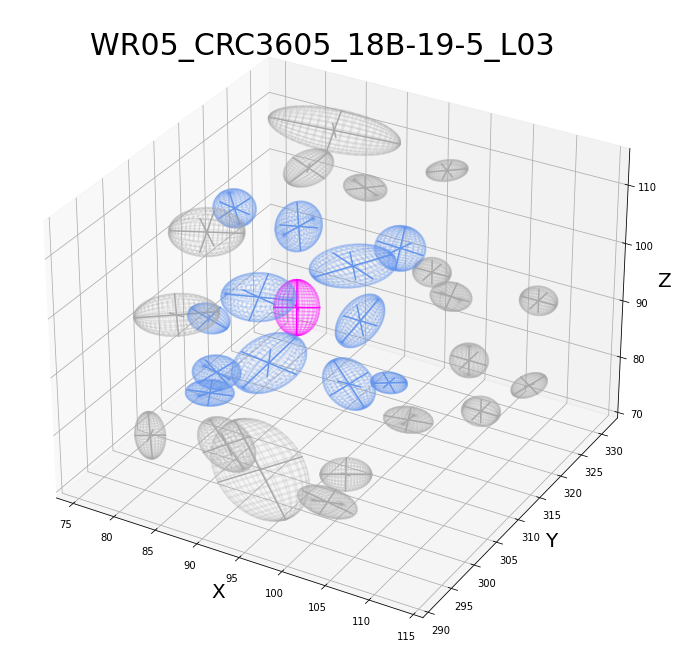

In [9]:
idx = 1000
fs = 20
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#lim = np.max(gland.shape)
#ax.set_xlim(240,275);ax.set_ylim(225, 260);ax.set_zlim(135, 170)

ax.set_xlabel('X', fontsize=fs); ax.set_ylabel('Y', fontsize=fs); ax.set_zlabel('Z', fontsize=fs)
for i in nind[idx ,:12]:
    et.plotEllipsoid(centers[i], amvee[i], rmvee[3*i:3*i+3], ax=ax, cageColor='cornflowerblue', 
                     plotAxes=True, cageAlpha=0.2)
for i in nind[idx ,12:30]:
    et.plotEllipsoid(centers[i], amvee[i], rmvee[3*i:3*i+3], ax=ax, cageColor='darkgray', 
                     plotAxes=True, cageAlpha=0.2)

et.plotEllipsoid(centers[idx], amvee[idx], rmvee[3*idx:3*idx+3], ax=ax, plotAxes=True, cageColor='magenta')
fig.suptitle(bname + '_' + lname, fontsize=fs+10, y=0.85)

filename = dst + 'ell_glands_{:05d}.jpg'.format(idx)
plt.savefig(filename,format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True},dpi=96)
print('Plotted', filename)

### Plot the distribution of distances to the 12 nearest neighbors

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/knn12_distance_vox_center.jpg


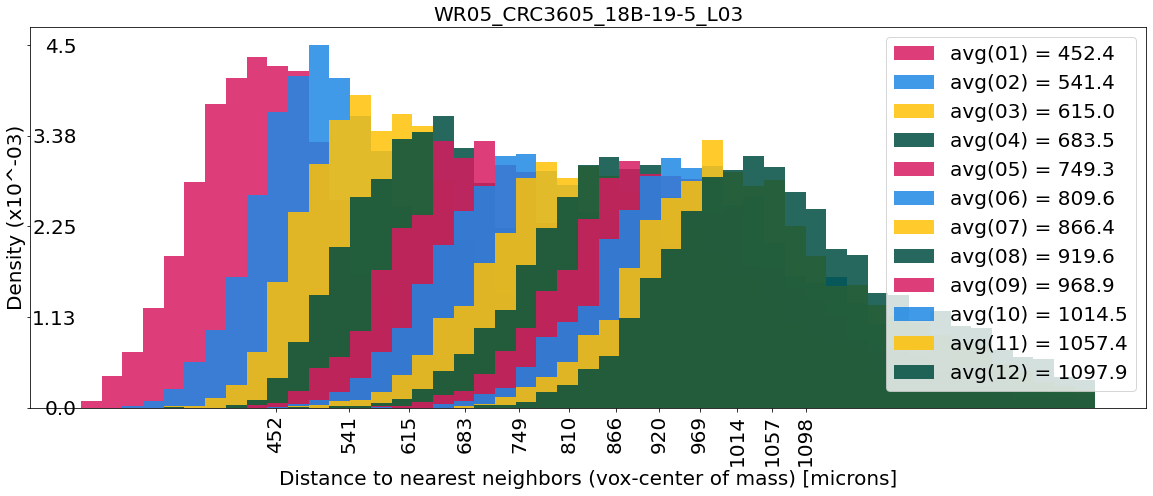

In [10]:
knn_max = 12
fs = 20

# The palette is meant to be color blind friendly
hcolors = ['#d81b60', '#1e88e5', '#ffc107', '#004d40']

nmax = np.zeros(knn_max)

bins = np.linspace(np.min(vdist[:,0]), np.max(vdist[:,3]), 50)

knn_idx = 0
fig, ax = plt.subplots(1,1,figsize=(20,7))

for knn_idx in range(knn_max):
    knn = vdist[:, knn_idx]
    h,b,r = ax.hist(knn, bins=bins, alpha=0.85, color = hcolors[knn_idx%len(hcolors)], density=True,
            label='avg({:02d}) = {:.1f}'.format(knn_idx+1, np.around(vavgs[knn_idx],1)),
            histtype = 'stepfilled', lw=1);
    nmax[knn_idx] = np.max(h)

yticks = np.linspace(0.0,np.max(nmax), 5)
base, exp = np.format_float_scientific(yticks[-1]).split('e')
eyticks = yticks*10**(-int(exp))
    
ax.legend(fontsize=fs);
ax.set_xlabel('Distance to nearest neighbors (vox-center of mass) [microns]', fontsize=fs);
ax.set_ylabel('Density (x10^{})'.format(exp), fontsize=fs)
ax.set_title(bname + '_' + lname, fontsize=fs);
ax.set_xticks(vavgs[:knn_max])
ax.set_xticklabels(np.around(vavgs[:knn_max], 0).astype(int))
ax.tick_params('x', labelsize=fs, labelrotation=90)

ax.set_yticks(yticks)
ax.set_yticklabels(np.around(eyticks, 2))
ax.tick_params('y', labelsize=fs, direction='out', pad=-50)

filename = dst + 'knn{:02d}_distance_vox_center.jpg'.format(knn_max)
fig.savefig(filename, dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
print('Plotted', filename)

### Save the kNN distances

In [11]:
knn = np.column_stack((vavgs, vvars, vstds))
columns = ['mean_dist_vox_center', 'variance_dist_vox_center', 'sd_dist_vox_center']
knn_filename = src + bname + '_' + lname + '_knn_vox_distances.csv'
pd.DataFrame(knn, columns=columns).to_csv(knn_filename, index=False)
print('Saved ', knn_filename)

Saved  ../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_knn_vox_distances.csv


### Surface-to-surface distance

Additionally, we can consider the distance from the oil gland ellipsoid surface to its neighboring ellipsoid surface.
- The distribution is essentially the same as center-to-center distance, just shifted by a constant.

In [12]:
vknn = np.zeros((non, len(centers), 3))
for knn_idx in range(non):
    vknn[knn_idx] = centers - centers[nind[:, knn_idx]]

glen = np.zeros((len(ndist), non))
glenn = np.zeros_like(glen)

for idx in range(len(ndist)):
    center = centers[idx]
    radii = amvee[idx]
    rotation = rmvee[3*idx:3*idx+3]
    invrot = np.linalg.inv(rotation)
    axes = vknn[:, idx, :].copy()
    for i in range(len(axes)):
        axes[i] = axes[i] @ invrot
    R2 = (axes[:,0]/radii[0])**2  + (axes[:,1]/radii[1])**2 + (axes[:,2]/radii[2])**2
    foo = axes/np.sqrt(R2).reshape(-1,1)
    glen[idx] = np.linalg.norm(foo, axis=1)
    
    axxes = -vknn[:, idx, :].copy()
    for i,idxx in enumerate(nind[idx, :non]):
        center = centers[idxx]
        radii = amvee[idxx]
        rotation = rmvee[3*idxx:3*idxx+3]
        invrot = np.linalg.inv(rotation)
        axxes[i] = axxes[i] @ invrot
        R2 = (axxes[i,0]/radii[0])**2  + (axxes[i,1]/radii[1])**2 + (axxes[i,2]/radii[2])**2
        foo = axxes[i]/np.sqrt(R2)
        glenn[idx, i] = np.linalg.norm(foo)

gdist = ndist[:, :non] - glen - glenn
vgdist = gdist*voxsize
#vgdist[vgdist < 0] = 0
gavgs = np.mean(vgdist, axis=0)
gvars = np.var(vgdist, axis=0, ddof=1)
gstds = np.std(vgdist, axis=0, ddof=1)

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/knn12_distance_ell_glands.jpg


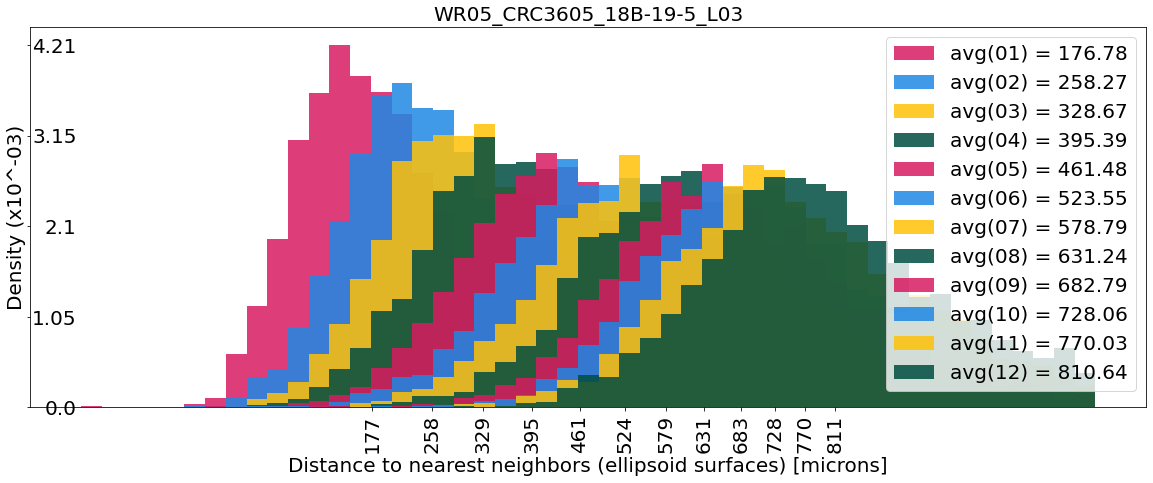

In [13]:
bins = np.linspace(np.min(vgdist[:, 0]), np.max(vgdist[:, 3]), len(bins))
nmax = np.zeros(knn_max)

knn_idx = 0
fig, ax = plt.subplots(1,1,figsize=(20,7))

for knn_idx in range(knn_max):
    knn = vgdist[:, knn_idx]
    h,b,r = ax.hist(knn, bins=bins, alpha=0.85, color = hcolors[knn_idx%len(hcolors)], density=True,
            label='avg({:02d}) = {:.2f}'.format(knn_idx+1, np.mean(knn)),
            histtype = 'stepfilled', lw=4);
    nmax[knn_idx] = np.max(h)
    
yticks = np.linspace(0.0,np.max(nmax), 5)
base, exp = np.format_float_scientific(yticks[-1]).split('e')
eyticks = yticks*10**(-int(exp))
    
ax.legend(fontsize=fs);
ax.set_xlabel('Distance to nearest neighbors (ellipsoid surfaces) [microns]', fontsize=fs);
ax.set_ylabel('Density (x10^{})'.format(exp), fontsize=fs)
ax.set_title(bname + '_' + lname, fontsize=fs);
ax.set_xticks(gavgs[:knn_max])
ax.set_xticklabels(np.around(gavgs[:knn_max], 0).astype(int))
ax.tick_params('x', labelsize=fs, labelrotation=90)

ax.set_yticks(yticks)
ax.set_yticklabels(np.around(eyticks, 2))
ax.tick_params('y', labelsize=fs, direction='out', pad=-50)

filename = dst + 'knn{:02d}_distance_ell_glands.jpg'.format(knn_max)
fig.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')
print('Plotted', filename)

### Save average surface-to-surface distances between neighbors

- Also keep track of variance and standard deviation

In [14]:
knn = np.column_stack((vavgs, vvars, vstds, gavgs, gvars, gstds))
columns = ['mean_dist_ell_center', 'variance_dist_ell_center', 'sd_dist_ell_center',
           'mean_dist_ell_glands', 'variance_dist_ell_glands', 'sd_dist_ell_glands']
knn_filename = src + bname + '_' + lname + '_knn_ell_distances.csv'
pd.DataFrame(knn, columns=columns).to_csv(knn_filename, index=False)
print('Saved ', knn_filename)

Saved  ../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_knn_ell_distances.csv


## Model oil glands with MVEEs

Compute sphericity indices

- There is no unique way to compute how sphere-like is a shape
- However, most of the common formulas are based-off the semi-axes lengths of the best-fit ellipsoid
- Check [Clayton _et al._ (2009)](https://doi.org/10.1680/geot.2007.00195) and [Blott and Pye (2008)](https://doi.org/10.1111/j.1365-3091.2007.00892.x) for more references.

More crudely, we can simply keep track of the sizes of the three different semi-axes

In [15]:
a,b,c = 1/(amvee**2).T
I = a + b + c
J = a*b + b*c + c*a
#K = np.linalg.det(np.array([[a, h, g], [h, b, f], [g, f, c] ]))
rho = (4*J - I*I)/(a**2 + b**2 + c**2)
rho = (rho + 1)*.5

c,b,a = amvee.T
krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(b*a))
equancy = c/a

sphere = (a == b) & (b==c)

t = np.arccos(c/a)
s = np.arccos(c/b)
k = np.sin(s)/np.sin(t)

area = c*c/(a*a)*special.ellipkinc(t, k*k) + np.sin(t)*np.sin(t)*special.ellipeinc(t, k*k)
area *= 2*np.pi*a*b/np.sin(t)
area += 2*np.pi*c*c
area[sphere] = 4*np.pi*a[sphere]*a[sphere]

volume = 4*np.pi*a*b*c/3

wadell = np.cbrt(36*np.pi*volume*volume)/area

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/gland_sphericity.jpg


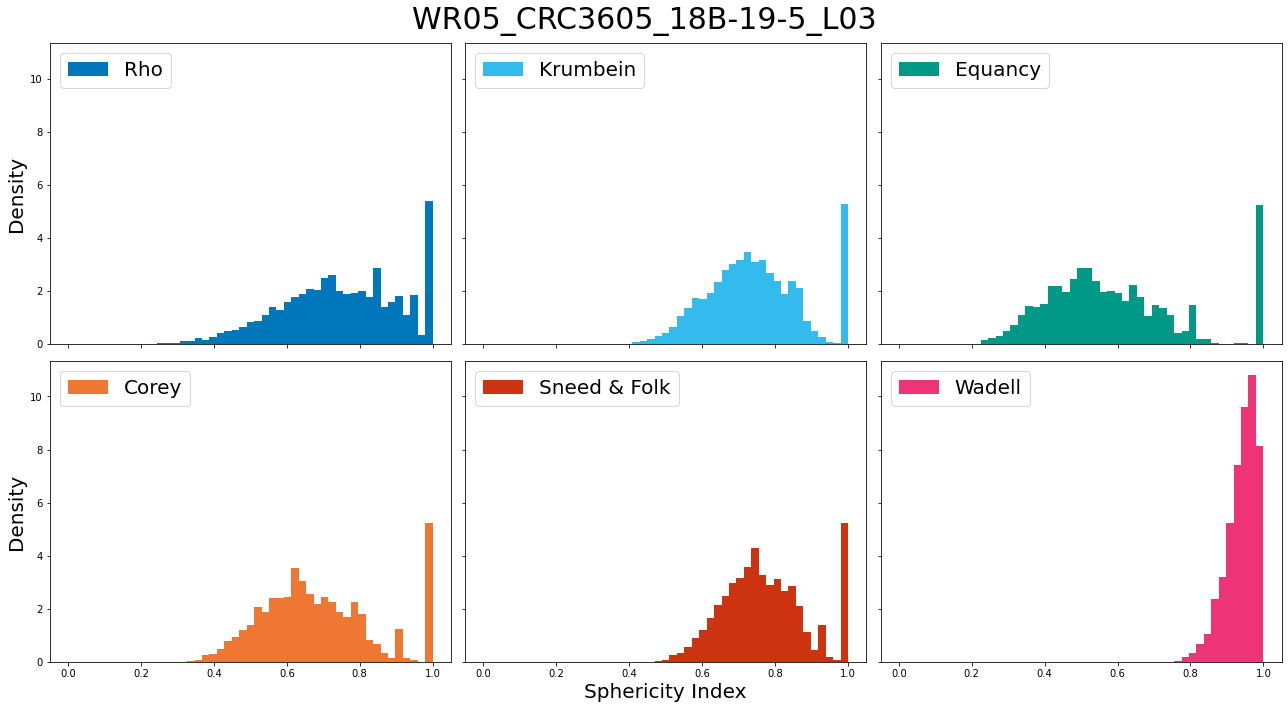

In [16]:
sbins = np.linspace(0,1,50)
slabels = ['Rho', 'Krumbein', 'Equancy', 'Corey', 'Sneed & Folk', 'Wadell']

# The palette is meant to be color blind friendly
colors = ['#0077bb', '#33bbee', '#009988', '#ee7733', '#cc3311', '#ee3377', '#bbbbbb']
sphericity = [rho, krumbein, equancy, corey, sneed, wadell]
fig, axes = plt.subplots(2,3,figsize=(18,10), sharex=True, sharey=True)

for i,ax in enumerate(axes.ravel()):
    ax.hist(sphericity[i], bins=sbins, alpha = 1, color=colors[i], density=True,
            label = slabels[i]);
    ax.legend(fontsize=fs, loc=2)
for i in range(axes.shape[0]):
    axes[i,0].set_ylabel('Density', fontsize=fs)
#for i in range(axes.shape[1]):
axes[1,1].set_xlabel('Sphericity Index', fontsize=fs)

fig.suptitle(bname + '_' + lname, fontsize=fs+10)

fig.tight_layout();
filename = dst + 'gland_sphericity.jpg'
fig.savefig(filename, dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
print('Plotted', filename)

### Distribution of semi-axes lengths and differences

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/gland_semiaxes.jpg


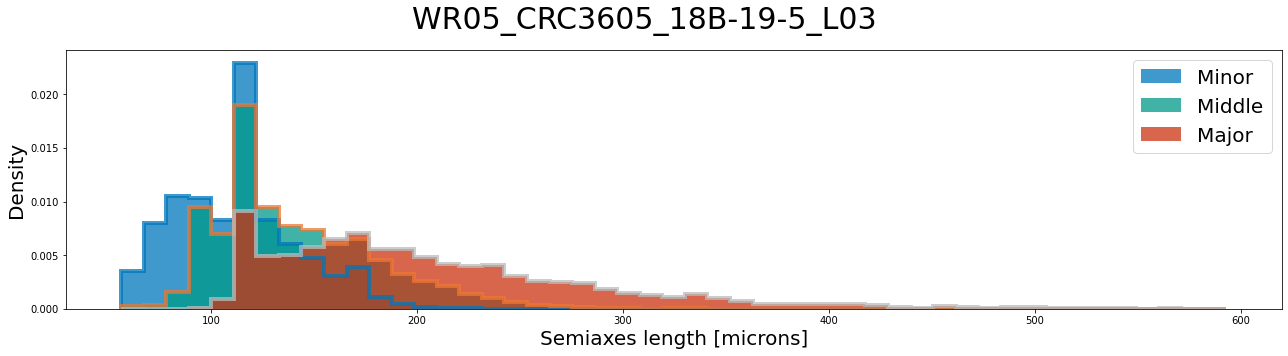

In [17]:
alabels = ['Minor', 'Middle', 'Major']
amveeT = amvee.T * voxsize
sbins = np.linspace(np.min(amveeT),np.max(amveeT),50)

fig, axes = plt.subplots(1,1,figsize=(18,5), sharex=True, sharey=True)

for i in range(3):
    axes.hist(amveeT[i], bins=sbins, alpha = 0.75, color=colors[2*i], density=True,
            label = alabels[i]);
    axes.hist(amveeT[i], bins=sbins, alpha = 0.75, color=colors[(3*i)%len(colors)], density=True,
            lw=4, histtype='step');
axes.legend(fontsize=fs, loc=1)
#for i in range(axes.shape[0]):
axes.set_ylabel('Density', fontsize=fs)
#for i in range(axes.shape[1]):
axes.set_xlabel('Semiaxes length [microns]', fontsize=fs)

fig.suptitle(bname + '_' + lname, fontsize=fs+10)

fig.tight_layout();
filename = dst + 'gland_semiaxes.jpg'
fig.savefig(filename, dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
print('Plotted', filename)

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/diff_semiaxes.jpg


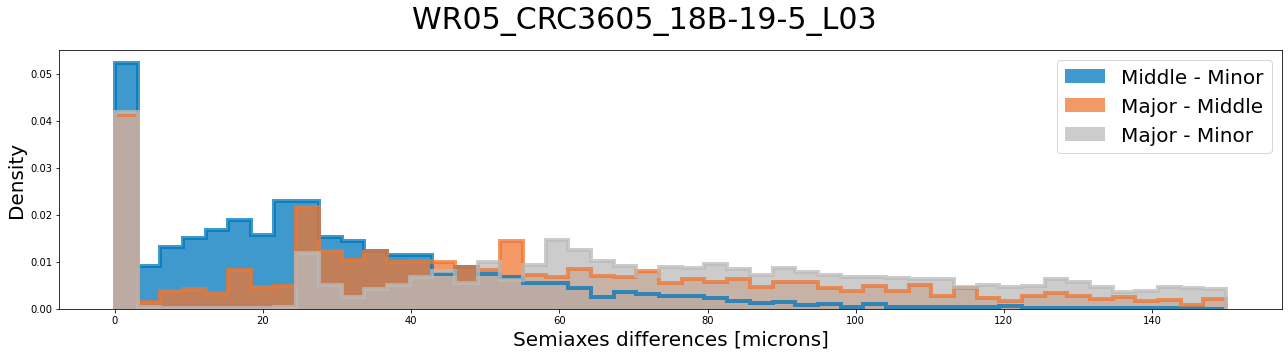

In [18]:
alabels = ['Middle - Minor', 'Major - Middle', 'Major - Minor']
sbins = np.linspace(0,150,50)#np.max(amveeT[2] - amveeT[1]), 50)

fig, axes = plt.subplots(1,1,figsize=(18,5), sharex=True, sharey=True)

for i in range(3):
    axes.hist(np.abs(amveeT[i] - amveeT[(i+1)%3]), bins=sbins, alpha = 0.75, color=colors[(3*i)%7], density=True,
            label = alabels[i], log=False, histtype='stepfilled', lw=4);
    axes.hist(np.abs(amveeT[i] - amveeT[(i+1)%3]), bins=sbins, alpha = 0.75, color=colors[(3*i)%7], density=True,
            log=False, histtype='step', lw=4);
axes.legend(fontsize=fs, loc=1)
axes.set_ylabel('Density', fontsize=fs)
axes.set_xlabel('Semiaxes differences [microns]', fontsize=fs)

fig.suptitle(bname + '_' + lname, fontsize=fs+10)

fig.tight_layout();
filename = dst + 'diff_semiaxes.jpg'
fig.savefig(filename, dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
print('Plotted', filename)

## Consider latitudes across the fruit

- Align the centers with the rotation matrix `vh` from previous steps.
- Scale the point cloud according to the voxel size of the scan
- We are interested in keeping track of oil gland traits depending on their latitute wrt the whole fruit

[[ 9.92111916e-01 -9.20178175e-02  8.51273630e-02]
 [-9.22832159e-02 -9.95732461e-01 -8.20533131e-04]
 [ 8.48395824e-02 -7.04176612e-03 -9.96369740e-01]]


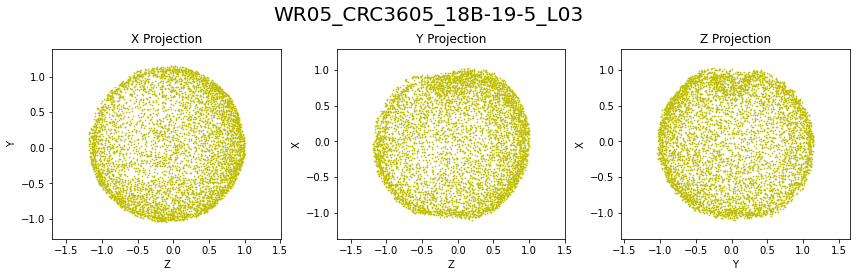

In [21]:
rotateby = [2,1,0]
filename = tissue_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vh_alignment.csv'
vh = np.loadtxt(filename, delimiter = ',')
print(vh)

glands = np.matmul(centers, np.transpose(vh))
centerby = np.mean(glands, axis = 0)
scaleby = 1e4/voxsize
glands = (glands - centerby)/scaleby
cglands = (glands.T)[rotateby]
ccglands = cglands.copy()

vitaminC.plot_3Dprojections(glands, title=bname+'_'+lname, writefig=False)

In [22]:
bbox = (np.max(glands, axis=0) - np.min(glands, axis=0))*.5
guess = np.argsort(np.argsort(bbox))
print(bbox)
print(guess[rotateby])

datapoints = glands.T
filename = oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vox_v_ell.csv'
ell_v_params = np.loadtxt(filename, delimiter=',')

filename = oil_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vox_m_ell.csv'
foo = np.loadtxt(filename, delimiter=',')
ell_params = {'center': foo[0],
              'axes': foo[1],
              'rotation': foo[2:5],
              'theta': foo[5]}
ell_params

[1.05911753 1.08946973 1.09470996]
[2 1 0]


{'center': array([-0.0210909 ,  0.02489648, -0.04087449]),
 'axes': array([1.06955982, 1.06829734, 1.02199553]),
 'rotation': array([[-0.20287374,  0.9710181 , -0.12635698],
        [ 0.20009144,  0.16742639,  0.96536616],
        [ 0.95854351,  0.17056449, -0.22825883]]),
 'theta': array([0.64173339, 1.28184603, 0.77849371])}

### Consider 25 latitudes

- 25 horizontal slices across the fruit's height
- 24 latitudinal strips
- We keep track of the average oil gland traits within every strip

In [23]:
H = 25
gmin = np.min(cglands, axis=1)
gmax = np.max(cglands, axis=1)
hlices = np.linspace(gmin[2], gmax[2], H)
print(gmin, gmax, hlices, sep='\n')

hvals = np.digitize(cglands[2], bins=hlices)
hist, _ = np.histogram(cglands[2], bins=hlices)
hvals[hvals == H] = H-1

[-1.18978054 -1.03568153 -1.09560832]
[0.99963938 1.14325793 1.02262675]
[-1.09560832 -1.00734852 -0.91908873 -0.83082893 -0.74256914 -0.65430934
 -0.56604955 -0.47778976 -0.38952996 -0.30127017 -0.21301037 -0.12475058
 -0.03649078  0.05176901  0.1400288   0.2282886   0.31654839  0.40480819
  0.49306798  0.58132778  0.66958757  0.75784736  0.84610716  0.93436695
  1.02262675]


In [24]:
sphavg = np.zeros((len(sphericity), H-1))
sphsd = np.zeros_like(sphavg)

for i,sphidx in enumerate(sphericity):
    for h in range(1, H):
        foo = sphidx[hvals == h]
        sphavg[i, h-1] = np.mean(foo)
        sphsd[i,h-1] = np.std(foo, ddof=1)

### Model average oil gland sphericity across latitudinal slices

- Also keep track of variance and standard deviation

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/hlices_sphericity.jpg


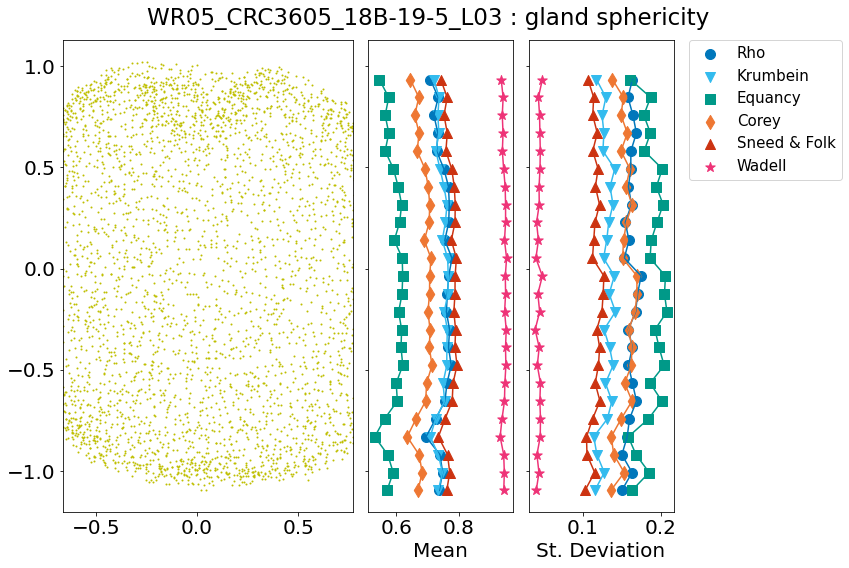

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(12,8), sharey=True, 
                       gridspec_kw={"width_ratios":[4,2,2,1]})
marker = ['o', 'v', 's', 'd', '^', '*']

ax[0].scatter(*ccglands[1:], s=1, color='y')
ax[0].axis('equal')
for i in range(len(sphericity)):
    ax[1].plot(sphavg[i], hlices[:-1], color=colors[i])
    ax[1].scatter(sphavg[i], hlices[:-1], color=colors[i], marker=marker[i], s=100, label=slabels[i])
for i in range(len(sphericity)):
    ax[2].plot(sphsd[i], hlices[:-1], color=colors[i])
    ax[2].scatter(sphsd[i], hlices[:-1], color=colors[i], marker=marker[i], s=100)
    
ax[1].set_xlabel('Mean', fontsize=fs)
ax[2].set_xlabel('St. Deviation', fontsize=fs)
for i in range(3):
    ax[i].tick_params(labelsize=fs)

h,l = ax[1].get_legend_handles_labels()
ax[3].legend(h,l, borderaxespad=0, fontsize=15, loc=2)
ax[3].axis("off")
title = bname + '_' + lname + ' : gland sphericity'
fig.suptitle(title, fontsize=fs+3)

fig.tight_layout();

filename = dst + 'hlices_sphericity.jpg'
fig.savefig(filename, dpi=72, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
print('Plotted', filename)

## Model the whole fruit as an ellipsoid

- The slices are now taken from the ellipsoid model rather than the fruit itself

In [26]:
footpoints = 'geocentric'

_, xyz = vitaminC.get_footpoints(datapoints, ell_params, footpoints)

eglands = xyz - ell_params['center'].reshape(-1,1)
eglands = eglands[rotateby]

In [27]:
eheight = ell_params['axes'][2]
helices = np.linspace(-eheight, eheight, H)

hevals = np.digitize(eglands[2], bins=helices)
heist, _ = np.histogram(eglands[2], bins=helices)
hevals[hevals == H] = H-1

In [28]:
esphavg = np.zeros((len(sphericity), H-1))
esphsd = np.zeros_like(sphavg)

for i, sphidx in enumerate(sphericity):
    for h in range(1, H):
        foo = sphidx[hevals == h]
        esphavg[i, h-1] = np.mean(foo)
        esphsd[i,h-1] = np.std(foo, ddof=1)

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/helices_sphericity.jpg


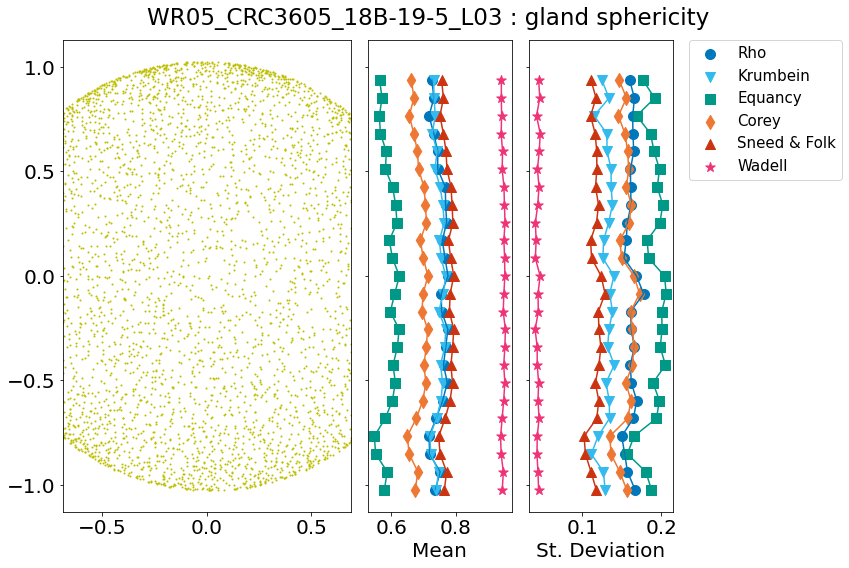

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(12,8), sharey=True, 
                       gridspec_kw={"width_ratios":[4,2,2,1]})
marker = ['o', 'v', 's', 'd', '^', '*']

ax[0].scatter(*eglands[1:], s=1, color='y')
ax[0].axis('equal')
for i in range(len(sphericity)):
    ax[1].plot(esphavg[i], helices[:-1], color=colors[i])
    ax[1].scatter(esphavg[i], helices[:-1], color=colors[i], marker=marker[i], s=100, label=slabels[i])
for i in range(len(sphericity)):
    ax[2].plot(esphsd[i], helices[:-1], color=colors[i])
    ax[2].scatter(esphsd[i], helices[:-1], color=colors[i], marker=marker[i], s=100)
    
ax[1].set_xlabel('Mean', fontsize=fs)
ax[2].set_xlabel('St. Deviation', fontsize=fs)
for i in range(3):
    ax[i].tick_params(labelsize=fs)

h,l = ax[1].get_legend_handles_labels()
ax[3].legend(h,l, borderaxespad=0, fontsize=15, loc=2)
ax[3].axis("off")
title = bname + '_' + lname + ' : gland sphericity'
fig.suptitle(title, fontsize=fs+3)

fig.tight_layout();

filename = dst + 'helices_sphericity.jpg'
fig.savefig(filename, dpi=72, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
print('Plotted', filename)

### Model average oil gland density, individual surface area, and individual volume across latitudes

- We also keep track of variance and standard deviation

In [30]:
theta = np.zeros_like(volume)
for idx in range(len(centers)):
    radii = amvee[idx]
    rotation = rmvee[3*idx:3*idx+3]
    cc = centers[idx]

    p = np.matmul(np.array([0.0,0.0,radii[2]]), rotation)
    X3 = np.linspace(-p[0], p[0], 2) + cc[0]
    Y3 = np.linspace(-p[1], p[1], 2) + cc[1]
    Z3 = np.linspace(-p[2], p[2], 2) + cc[2]
    
    foo = np.array([X3[0],Y3[0],Z3[0]])
    bar = np.array([X3[1],Y3[1],Z3[1]])
    
    foo2, bar2 = ((np.vstack((foo, bar)) @ vh.T) - centerby)/scaleby - ell_params['center'].reshape(1,-1)
    foo2 = foo2[rotateby]
    bar2 = bar2[rotateby]
    
    foobar = foo2 - bar2
    theta[idx] = (.5*np.pi - np.arccos((np.abs(foobar[2]))/np.linalg.norm(foobar)))

In [31]:
gpheno = [volume/np.max(volume), area/np.max(area), theta/(.5*np.pi)]

gphenoavg = np.zeros((len(gpheno), H-1))
gphenosd = np.zeros_like(gphenoavg)

for i,sphidx in enumerate(gpheno):
    for h in range(1, H):
        foo = sphidx[hvals == h]
        gphenoavg[i, h-1] = np.mean(foo)
        gphenosd[i,h-1] = np.std(foo, ddof=1)

egphenoavg = np.zeros((len(gpheno), H-1))
egphenosd = np.zeros_like(gphenoavg)

for i,sphidx in enumerate(gpheno):
    for h in range(1, H):
        foo = sphidx[hevals == h]
        egphenoavg[i, h-1] = np.mean(foo)
        egphenosd[i,h-1] = np.std(foo, ddof=1)

In [32]:
prcglands = hist/np.sum(hist)*100
percglands = heist/np.sum(heist)*100

Plotted ../data/glands/WR05_CRC3605_18B-19-5/L03/helices_phglands.jpg


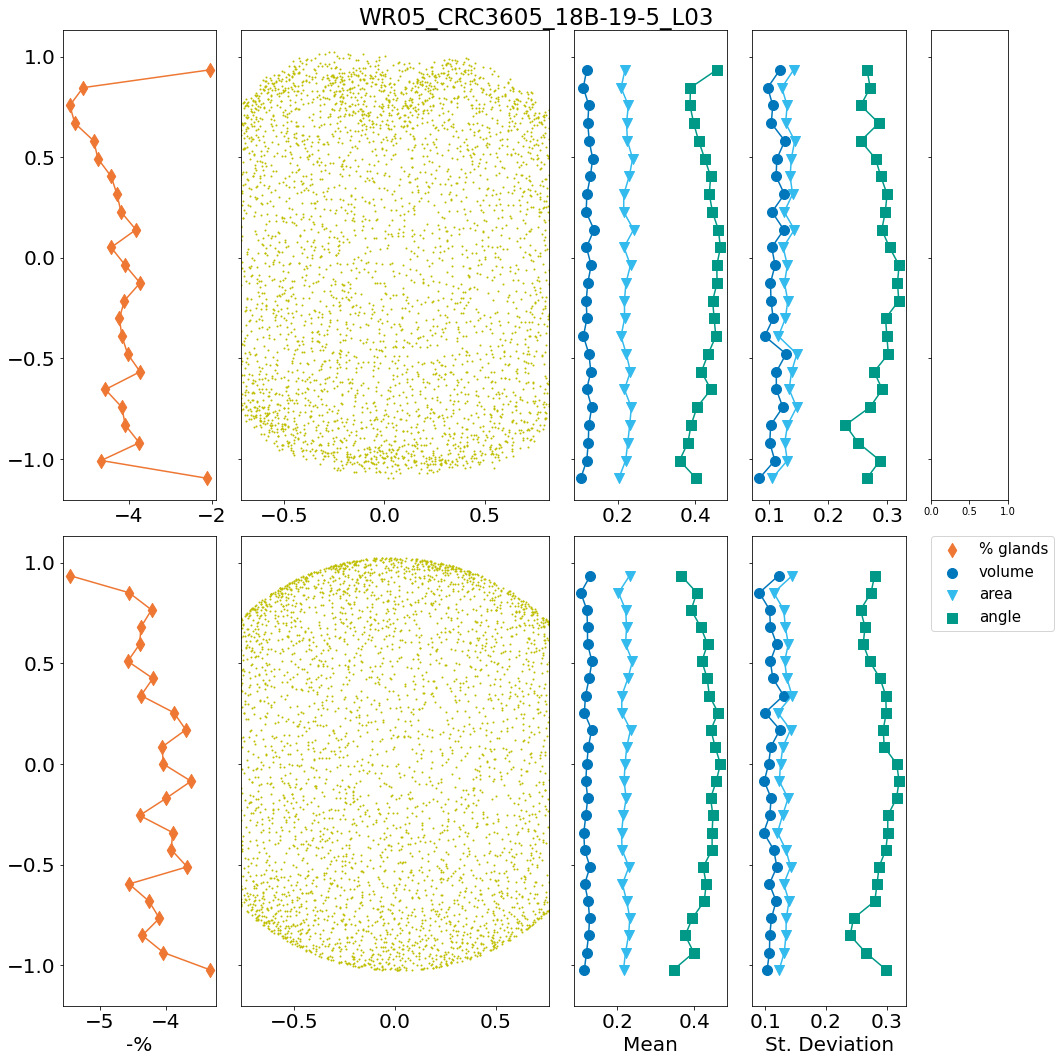

In [33]:
phlabels = ['volume', 'area', 'angle']
fig, ax = plt.subplots(2, 5, figsize=(15,15), sharey=True, 
                       gridspec_kw={"width_ratios":[2,4,2,2,1]})

ax[0,0].scatter(-prcglands, hlices[:-1], color=colors[len(gpheno)], marker=marker[len(gpheno)], s = 100,
              label = '% glands')
ax[0,0].plot(-prcglands, hlices[:-1], color=colors[len(gpheno)])

ax[1,0].scatter(-percglands, helices[:-1], color=colors[len(gpheno)], marker=marker[len(gpheno)], s = 100,
              label = '% glands')
ax[1,0].plot(-percglands, helices[:-1], color=colors[len(gpheno)])
ax[1,0].set_xlabel('-%', fontsize=fs)

ax[1,1].scatter(*eglands[1:], s=1, color='y')
ax[1,1].axis('equal')

ax[0,1].scatter(*ccglands[1:], s=1, color='y')
ax[0,1].axis('equal')
for i in range(len(gpheno)):
    ax[0,2].plot(gphenoavg[i], hlices[:-1], color=colors[i])
    ax[0,2].scatter(gphenoavg[i], hlices[:-1], color=colors[i], marker=marker[i], s=100, label=phlabels[i])
    
    ax[1,2].plot(egphenoavg[i], helices[:-1], color=colors[i])
    ax[1,2].scatter(egphenoavg[i], helices[:-1], color=colors[i], marker=marker[i], s=100, label=phlabels[i])
for i in range(len(gpheno)):
    ax[0,3].plot(gphenosd[i], hlices[:-1], color=colors[i])
    ax[0,3].scatter(gphenosd[i], hlices[:-1], color=colors[i], marker=marker[i], s=100)
    
    ax[1,3].plot(egphenosd[i], helices[:-1], color=colors[i])
    ax[1,3].scatter(egphenosd[i], helices[:-1], color=colors[i], marker=marker[i], s=100)
    
ax[1,2].set_xlabel('Mean', fontsize=fs)
ax[1,3].set_xlabel('St. Deviation', fontsize=fs)
for i in range(4):
    ax[0,i].tick_params(labelsize=fs)
    ax[1,i].tick_params(labelsize=fs)

h, l = ax[1,0].get_legend_handles_labels()
hh, ll = ax[1,2].get_legend_handles_labels()
h += hh
l += ll
ax[1,4].legend(h,l, borderaxespad=0, fontsize=15, loc=2)
ax[1,4].axis("off")
fig.suptitle(bname + '_' + lname, fontsize=fs+3)

fig.tight_layout();

filename = dst + 'helices_phglands.jpg'
fig.savefig(filename, dpi=72, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
print('Plotted', filename)

### Store all the above results when the latitudinal slices are taken from the fruit itself

In [34]:
gland_pheno = np.column_stack((hlices[:-1], sphavg.T, sphsd.T, prcglands, gphenoavg.T, gphenosd.T))
columns = ['height', 
           'avg_rho', 'avg_krumbein', 'avg_equancy', 'avg_corey', 'avg_sneed', 'avg_wadell',
           'sd_rho', 'sd_krumbein', 'sd_equancy', 'sd_corey', 'sd_sneed', 'sd_wadell',
           'percentage_of_glands',
           'avg_volume', 'avg_area', 'avg_angle',
           'sd_volume', 'sd_area', 'sd_angle']
pheno_filename = src + bname + '_' + lname + '_glands_phenotypes.csv'
pd.DataFrame(gland_pheno, columns=columns).to_csv(pheno_filename, index=False)
print('Saved', pheno_filename)

Saved ../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_glands_phenotypes.csv


### Store all the above results when the latitudinal slices are taken from the modeled fruit ellipsoid

In [35]:
gland_pheno = np.column_stack((helices[:-1], esphavg.T, esphsd.T, percglands, egphenoavg.T, egphenosd.T))
columns = ['height', 
           'avg_rho', 'avg_krumbein', 'avg_equancy', 'avg_corey', 'avg_sneed', 'avg_wadell',
           'sd_rho', 'sd_krumbein', 'sd_equancy', 'sd_corey', 'sd_sneed', 'sd_wadell',
           'percentage_of_glands',
           'avg_volume', 'avg_area', 'avg_angle',
           'sd_volume', 'sd_area', 'sd_angle']
pheno_filename = src + bname + '_' + lname + '_ellipsoid_phenotypes.csv'
pd.DataFrame(gland_pheno, columns=columns).to_csv(pheno_filename, index=False)
print('Saved', pheno_filename)

Saved ../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_ellipsoid_phenotypes.csv


# References

- **Blott, SJ**, **Pye, K** (2008) Particle shape: a review and new methods of characterization and classification. _Sedimentology_ **55**(1), 31-63. [DOI: 10.1111/j.1365-3091.2007.00892.x](https://doi.org/10.1111/j.1365-3091.2007.00892.x)

- **Clayton, CRI**, **Abbireddy, COR**, **Schiebel, R** (2009) A method of estimating the form of coarse particulates. _Géotechnique_ **59**(6), 493-501. [DOI: 10.1680/geot.2007.00195](https://doi.org/10.1680/geot.2007.00195)